In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Notebook goal is to model gridcells as a twisted torus using velocity as an input, using equations from Guanella and Verschure 2007

**Reference**
\
\
$N:$ Number of neurons
\
$N_{x}:$ Width
\
$N_{y}:$ Height
\
$A:$ Activity matrix of shape $x$ by $y$
\
$I:$ Intensity parameter, defining the overall strength of the synapses
\
$\sigma:$ Regulates the size of the Gaussian
\
$T:$ Shift parameter determining excitatory and inhibitory zones
\
$\alpha:$ The gain (distance between receptive fields)
\
$\beta:$ The bias (angle of receptive fields) $[0, \pi/3]$

In [2]:
#Only Ny needs to be defined, but writing out for clarity
#Nx = Ny + 1, N = Nx * Ny
Ny = 9
Nx = 10
N = 90

Initialize neuron activity randomly distributed between $0$ and $1/\sqrt{N}$

**Activity Eqs.**
\
\
$B_{i}(t+1) = A_{i}(t) + \sum \limits _{j=1}^{N}A_{j}(t)w_{ji}$ 
\
$A_{i}(t+1) = B_{i}(t+1) + \tau\Bigg(\frac{B_{i}(t+1)}{<B_{j}(t+1)>_{j=1}^{N}}-B_{i}(t+1)\Bigg)$
\
\
Function $< . >_{j=1}^{N}$ is the mean over the cells of the network, used to ensure stability \
\
Therefore $<B_{j}(t+1)>_{j=1}^{N}$ is an external cell that keeps things stable \
\
$A_{i}(t+1) = 0$ when $A_{i}(t+1)$ is smaller than 0 \
\
\
**Synapse Eqs.**
\
\
$w_{ij} = I\exp{(-\frac{||c_{i}-c_{j}||_{tri}^2}{\sigma^2})} - T$
\
\
*Where $c_{i} = (c_{ix},c_{iy})$ is the position of cell $i$, $c_{ix} = (i_{x} + 0.5)/N_{x}$ and $c_{iy} = \frac{\sqrt{3}}{2}(i_{y} + 0.5)/N_{y}$ 
\
\
$dist_{tri}(c_{i},c_{j}) := ||c_{1}-c_{2}||_{tri} = \min_{j=1}^{7}||c_{1}-c_{2}+s_{j}||$




$s_{1} := (0,0),$
\
\
$s_{2} := (-0.5,\frac{\sqrt{3}}{2}),$
\
\
$s_{3} := (-0.5,-\frac{\sqrt{3}}{2}),$
\
\
$s_{4} := (0.5,\frac{\sqrt{3}}{2}),$
\
\
$s_{5} := (0.5,-\frac{\sqrt{3}}{2})$
\
\
$s_{6} := (-1,0),$
\
\
$s_{7} := (1,0),$

*Equation changed slightly from paper to adjust for indices starting at 0

**Modulation Eqs**
\
\
$R_{\beta} = \begin{pmatrix} \cos(\beta) & -\sin(\beta) \\ \sin(\beta) & \cos(\beta) \end{pmatrix} = \cos(\beta) + i\sin(\beta)$

$w_{ij}(t+1) = I\exp\bigg(-\frac{||c_{i}-c_{j}+\alpha R_{\beta}v(t)||^2_{tri}}{\sigma^2}\bigg) - T$

To calculate activity $A$, we need the weight matrix $W$. To calculate the weights, we need the receptive field locations $(c_{x},c_{y})$, which are stored in the matrix $C$

$i_{x}, i_{y}$ are indices in the range $0$ to $N_{x}, N_{y}$, whilst $i$ is the index in range $0$ to $N$ 

**Exploration Start**
\
\
To start, let's go through the equations one by one, following them without the use of matrices. This will be less efficient, but will allow us to make sure everthing is working.
\
\
We'll begin by setting up the coordinate matrix $C$, which stores the rectangular locations of the cells' receptive fields. I say rectangular rather than triangular because it will be 'twisted' by the $tri$ distribution later on

In [3]:
#x and y coords
Cx = (np.arange(Nx)+(0.5))/Nx
Cy = ((np.arange(Ny)+(0.5))/Ny)*np.sqrt(3)/2

#Creating a mesh, so we end up with Nx by Ny coords (N)
Tx, Ty = np.asarray(np.meshgrid(Cx, Cy))

#Combining and adding a complex j (i) component to represent the y-coord. Make things easier later on if we don't make this into a 2d array
C = (Tx+1j * Ty).reshape(-1,1)

In [4]:
#Printing first 5 values
print(C[:5])

[[0.05+0.04811252j]
 [0.15+0.04811252j]
 [0.25+0.04811252j]
 [0.35+0.04811252j]
 [0.45+0.04811252j]]


Now we'll compute the initial weights. To do this, we will need to twist the rectangular coordinates using the $tri$ distribution.

In [5]:
#Values for s from paper, used to create triangular tesselation.
S = [ 0+1j*0, -0.5+1j*np.sqrt(3)/2, -0.5+1j*(-np.sqrt(3)/2), 0.5+1j*np.sqrt(3)/2, 0.5+1j*(-np.sqrt(3)/2), -1+1j*0, 1+1j*0]

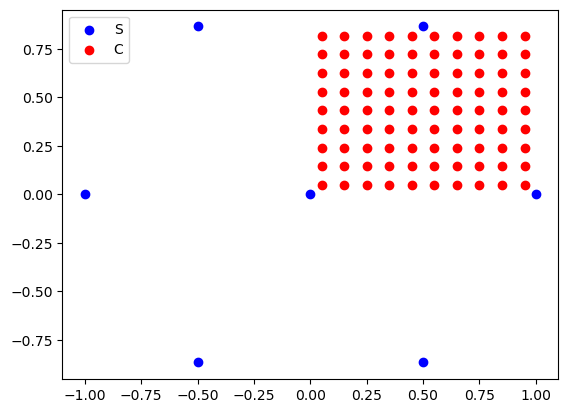

In [6]:
#Plotting for visualization, not needed by actual model

#S coords
sx = [s.real for s in S]
sy = [s.imag for s in S]
#C coords
cx = [c.real for c in C]
cy = [c.imag for c in C]

plt.scatter(sx,sy, color='blue', label='S')
plt.scatter(cx,cy, color='red', label='C')
plt.legend()
plt.show()

By fitting with S (Blue) we can twist C (Red) into a triangular distribution. NOW, we'll actually move onto the weight initialization: both with and without the triangular tesselation

In [7]:
#Empy weight matrix
w = np.zeros((N,N))
#Parameter values taken from paper
I = 0.3
T = 0.05
sigma = 0.24

for i in range(N):
    for j in range(N):
        #dist_tri function
        tri = np.abs(C[i] - C[j])
        for s in S:
            d = np.abs(C[i] - C[j] + s)
            if d < tri:
                tri = d
        w[i][j] = I * np.exp(-(tri**2)/(sigma**2)) - T

#Empy testing weight matrix
w_test = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        #This time, no need for a dist_tri function
        tri = np.abs(C[i] - C[j])
        w_test[i][j] = I * np.exp(-(tri**2)/(sigma**2)) - T

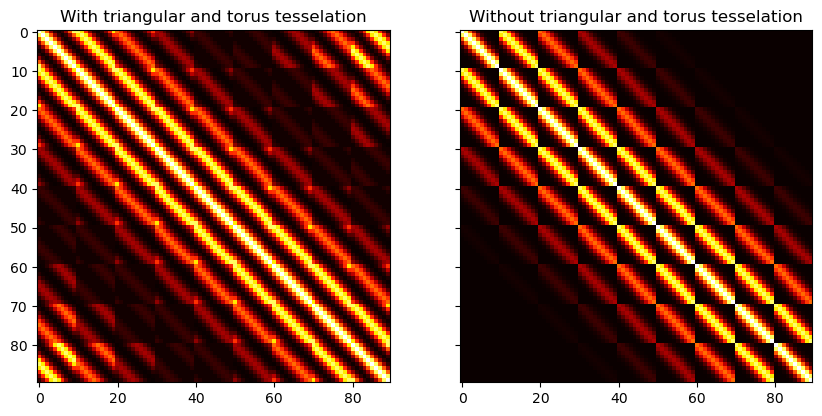

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches((10,10))
ax1.imshow(w, cmap='hot', interpolation='nearest')
ax1.title.set_text("With triangular and torus tesselation")
ax2.imshow(w_test, cmap='hot', interpolation='nearest')
ax2.title.set_text("Without triangular and torus tesselation")
plt.show()

Cool! As you can see, neurons have strong connections to themselves and their neighbors, with those connections steadily weakening the further you get away. 
\
\
With a triangular tesselation, we can see the distribution of connections is much smoother. And, thanks to the torus, neurons on opposite sides are considered neighbors.

Ok! Let's calculate the activity.

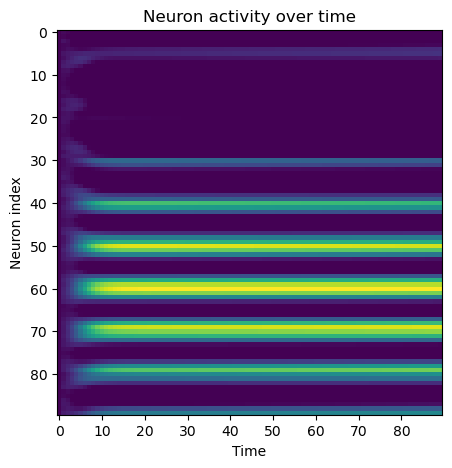

In [9]:
#Activity initialized randomly as per paper
np.random.seed(41)
def initA(Nx, Ny):
    return np.random.uniform(0, 1/np.sqrt(N), N)

T = 90
A = initA(Nx, Ny)

#Stores A and B at each timestep
At = np.zeros((T, N))

At[0] = A

Bt = np.zeros((T, N))


tau = 0.8

for t in range(T-1):
    Bt[t+1] = At[t] + At[t]@w.T

    At[t+1] = Bt[t+1] + tau*((Bt[t+1]/np.mean(Bt[t+1])) - Bt[t+1])

    At[At<0] = 0

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((5,5))
ax.imshow(At.T)
ax.title.set_text("Neuron activity over time")
ax.set_ylabel("Neuron index")
ax.set_xlabel("Time")
plt.show()

Sick! The activity is unchanging because we did not include any velocity in the model; so essentially it's like the agent is standing still. Still, we can see that one neuron is the most active, followed by it's twisted torus neighbors. The exact neuron that is most active changes based on the random initialization.

Let's add velocity! To keep things simple, we'll start by simulating an agent moving in a straight line at a constant velocity. 
\
\
We will also make a slight change to the weight calculation. Because it now must be calculated at each timestep, we will use matrix multiplication to make things more efficient.

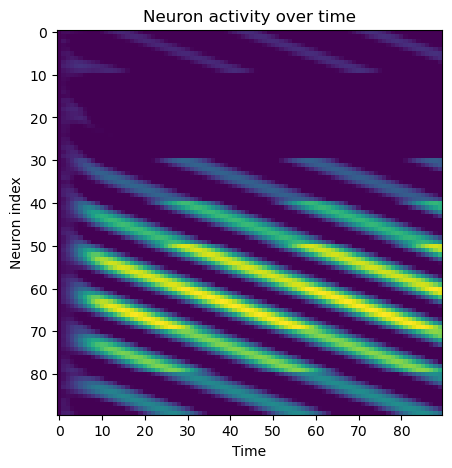

In [25]:
v = 0.05 + 0j

np.random.seed(41)
#Activity initialized randomly as per paper
def initA(Nx, Ny):
    return np.random.uniform(0, 1/np.sqrt(N), N)

#x and y coords
Cx = (np.arange(Nx)+(0.5))/Nx
Cy = ((np.arange(Ny)+(0.5))/Ny)*np.sqrt(3)/2

#Creating a mesh, so we end up with Nx by Ny coords (N)
Tx, Ty = np.asarray(np.meshgrid(Cx, Cy))

#Combining and adding a complex j (i) component to represent the y-coord. Make things easier later on if we don't make this into a 2d array
C = (Tx+1j * Ty).reshape(-1,1)

Ci = (C@np.ones_like(C.T)).T
Cj = Ci.T

Time = 90
A = initA(Nx, Ny)

#Stores A and B at each timestep
At = np.zeros((Time, N))
At[0] = A
Bt = np.zeros((Time, N))

tau = 0.8

#Empy weight matrix
w = np.zeros((Time,N,N))
#Parameter values taken from paper
I = 0.3
T = 0.05
sigma = 0.24

for t in range(Time-1):

    D = Ci - Cj + v

    for s in range(len(S)):
        distance = Ci - Cj + v + S[s]
        idx = np.where(np.abs(distance)<np.abs(D))
        D[idx] = distance[idx]
    w[t] = I * np.exp(-(np.abs(D)**2)/sigma**2) - T

    Bt[t+1] = At[t] + At[t]@w[t].T

    At[t+1] = Bt[t+1] + tau*((Bt[t+1]/np.mean(Bt[t+1])) - Bt[t+1])

    At[At<0] = 0

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((5,5))
ax.imshow(At.T)
ax.title.set_text("Neuron activity over time")
ax.set_ylabel("Neuron index")
ax.set_xlabel("Time")
plt.show()

Hell yeah! The velocity here is positive, constant, and horizontal (real). Let's try some changing velocity data taken from a simulation

In [11]:
vdata = pd.read_csv('velocity_data.csv')
vdata = np.asarray(vdata[['x','z']])
vcomplex = (vdata[:,0] + vdata[:,1]*1j)/10
pdata = np.asarray([[0,0]])
for i in range(len(vdata)):
    pdata = np.vstack((pdata, (np.sum(vdata[:i], axis=0))))

In [12]:
#x and y coords
Cx = (np.arange(Nx)+(0.5))/Nx
Cy = ((np.arange(Ny)+(0.5))/Ny)*np.sqrt(3)/2

#Creating a mesh, so we end up with Nx by Ny coords (N)
Tx, Ty = np.asarray(np.meshgrid(Cx, Cy))

#Combining and adding a complex j (i) component to represent the y-coord. Make things easier later on if we don't make this into a 2d array
C = (Tx+1j * Ty).reshape(-1,1)

Ci = (C@np.ones_like(C.T)).T
Cj = Ci.T

Time = len(vcomplex)
A = initA(Nx, Ny)

#Stores A and B at each timestep
At = np.zeros((Time, N))
At[0] = A
Bt = np.zeros((Time, N))

tau = 0.8

#Empy weight matrix
w = np.zeros((Time,N,N))
#Parameter values taken from paper
I = 0.3
T = 0.05
sigma = 0.24

for t in range(Time-1):

    D = Ci - Cj + vcomplex[t]

    for s in range(len(S)):
        distance = Ci - Cj + vcomplex[t] + S[s]
        idx = np.where(np.abs(distance)<np.abs(D))
        D[idx] = distance[idx]
    w[t] = I * np.exp(-(np.abs(D)**2)/sigma**2) - T

    Bt[t+1] = At[t] + At[t]@w[t].T

    At[t+1] = Bt[t+1] + tau*((Bt[t+1]/np.mean(Bt[t+1])) - Bt[t+1])

    At[At<0] = 0

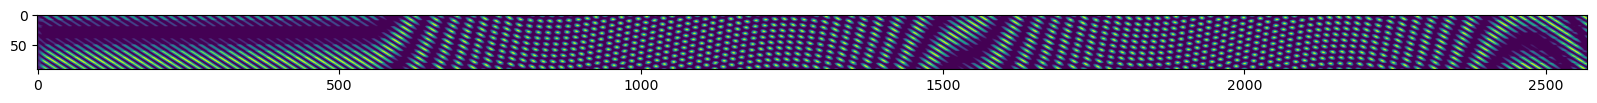

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(At.T)
plt.show()

Wow! You can see clearly how the activity changes based on the direction and magnitude of the velocity. Below is a plot of the position as the simulated agent moves according to it's velocity. We'll add the activity pattern of one neuron to give some idea of what's happening. Notice how constant the pattern is when it is travelling horizontally and vertically compared to when it moves at a diagonal

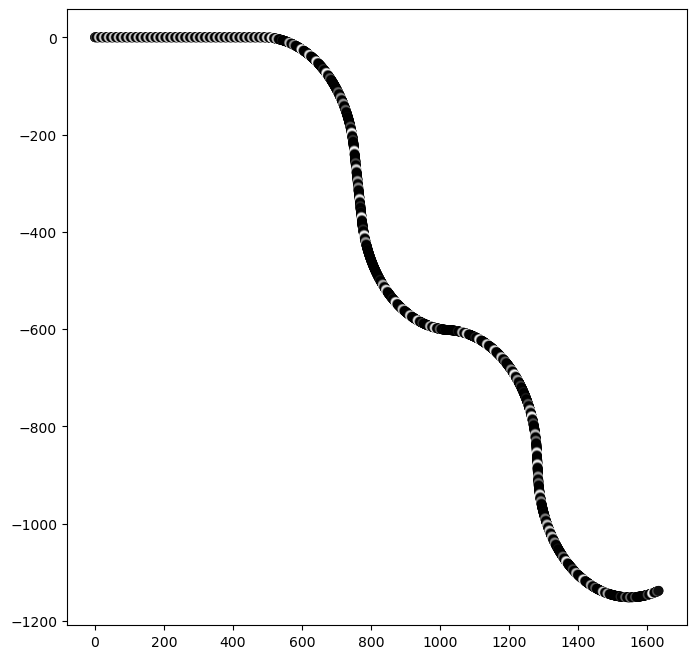

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax.scatter(pdata[:-1,0],pdata[:-1,1], c=At[:,60], cmap='gray')
#ax.scatter(pdata[:-1,0],pdata[:-1,1])
plt.show()

That's crazy. Time to add bias and gain! We'll also move everything into a class to make things easier.

In [156]:
class grid_module():
    def __init__(self, Nx ,Ny, gain, bias, I, sigma, tau, Tc, seed=None):
        self.Nx = Nx
        self.Ny = Ny
        self.gain = gain
        self.bias = bias
        self.I = I
        self.sigma = sigma
        self.tau = tau
        self.Tc = Tc

        #Used to twist the torus
        self.S = [ 0+1j*0, -0.5+1j*np.sqrt(3)/2, -0.5+1j*(-np.sqrt(3)/2), 0.5+1j*np.sqrt(3)/2, 0.5+1j*(-np.sqrt(3)/2), -1+1j*0, 1+1j*0]

        #total number of neurons
        self.N = Nx*Ny
        np.random.seed(seed)
        #Activity Matrix
        self.A = self.init_A()
        #Firing Matrix
        self.F = np.zeros_like(self.A)
        #Coord matrix, Ci - Cj
        self.C, self.Cij = self.init_C()
        #Initialize weight matrix
        self.w = self.update_w(0)

        #Storage matrices of length(timesteps), stores values at each timestep
        self.At = np.copy(self.A)
        self.wt = np.copy(self.w)
        self.Ft = np.copy(self.F)

        #Used for plotting, stores velocity and position at each timestep
        # self.vt = [0]
        # self.post = np.asarray[0 + 0j]

    def init_A(self):
        """
        Initializes neuron activity matrix A with random values from 0 to 1/sqrt(N)
        """
        return np.random.uniform(0, 1/np.sqrt(self.N), self.N)

    def init_C(self):
        """
        Initializes neuron coordinate matrix C
        """
        Cx = (np.arange(self.Nx)+(0.5))/self.Nx
        Cy = ((np.arange(self.Ny)+(0.5))/self.Ny)*np.sqrt(3)/2
        Tx, Ty = np.asarray(np.meshgrid(Cx, Cy))
        C = (Tx + 1j*Ty).reshape(-1,1)
        Ci = (C@np.ones_like(C.T)).T
        Cj = Ci.T

        return C, Ci - Cj

    def dist_tri(self, v):
        """
        Creates distribution
        """

        R = np.cos(self.bias) + 1j*np.sin(self.bias)

        D = self.Cij + self.gain*R*v

        for s in range(len(self.S)):
            distance = self.Cij + self.gain*R*v + self.S[s]
            idx = np.where(np.abs(distance)<np.abs(D))
            D[idx] = distance[idx]
            
        return D

    def update_w(self, v):
        """
        Updates weight matrix based on velocity
        """
        return self.I * np.exp(-(np.abs(self.dist_tri(v))**2)/self.sigma**2) - self.Tc

    def update_A(self, v):
        """
        Update activity
        """
        B = self.A + self.A@self.w.T
        A = B + self.tau*((B/np.mean(B)) - B) 
        A[A<0] = 0
        return A

    def update(self, v):
        """
        Update activity and weights for new timestep
        """
        self.w = self.update_w(v)
        self.A = self.update_A(v)
        self.F = np.zeros_like(self.A)
        self.F[np.argmax(self.A)] = 1

        self.wt = np.vstack((self.wt, self.w))
        self.At = np.vstack((self.At, self.A))
        self.Ft = np.vstack((self.Ft, self.F))

        return
        

In [107]:
module = grid_module(10, 9, 1, 0, 0.3, 0.24, 0.8, 0.05)

In [171]:
module = grid_module(6, 5, 0.5, 0, 0.3, 0.24, 0.8, 0.05)
for v in vcomplex:
    module.update(v)

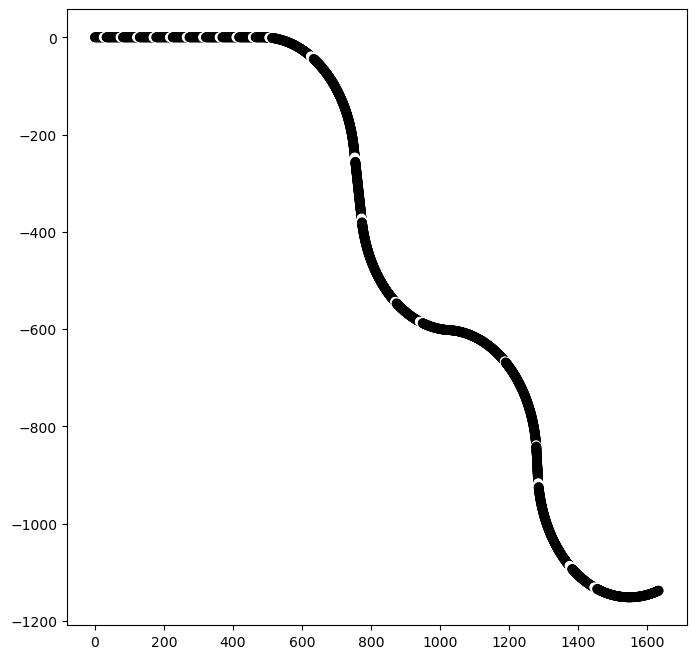

In [178]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax.scatter(pdata[:,0],pdata[:,1], c=module.Ft[:,25], cmap='gray')
#ax.scatter(pdata[:-1,0],pdata[:-1,1])
plt.show()